### Preparation of the NUTS data folder

this preparation is important in order to fill the missing values on Area in the Economic data.
AS well, we used the distances between centroids of each NUTS to enhance the features and consider the macroeconomic and climate variables in the surrounding areas for each NUTs code (60, 150 km)

In [17]:
import pandas as pd
import requests
import numpy as np
import glob
import os
import boto3
from io import BytesIO
import matplotlib.pyplot as plt
import geopandas as gpd
import s3fs

In [18]:
bucket_name = 'ecb-hackathon-data-group05-x19s00'
folder_path = 'economic_data/regional_boundaries'

# Create a S3 filesystem object
fs = s3fs.S3FileSystem(anon=False)  # Set anon to False to use your AWS credentials

# Construct the full path to the shapefile
shapefile_path = f's3://{bucket_name}/{folder_path}/NUTS_RG_20M_2021_3035.shp'

# Use Geopandas to read the shapefile directly from S3
gdf = gpd.read_file(shapefile_path, storage_options={'s3': fs})

In [19]:
# List of country codes for EU28
EU28_countries = ['BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'EL', 'ES', 'FR', 'HR', 'IT', 'CY', 'LV', 'LT', 'LU', 'HU', 'MT', 'NL', 'AT', 'PL', 'PT', 'RO', 'SI', 'SK', 'FI', 'SE']

# Filter the GeoDataFrame
gdf = gdf[gdf['CNTR_CODE'].isin(EU28_countries)]

In [20]:
# add area of region in km^2
gdf['area'] = gdf.geometry.area / 10**6

In [21]:
# add centroid
gdf['centroid'] = gdf.geometry.centroid

gdf['centroid'] = gdf['centroid'].apply(lambda x: f"({x.x}, {x.y})")

In [22]:
gdf.head()

NUTS_ID  LEVL_CODE CNTR_CODE        NAME_LATN        NUTS_NAME  MOUNT_TYPE  \
0      FR          0        FR           France           France         0.0   
1      HR          0        HR         Hrvatska         Hrvatska         0.0   
2      HU          0        HU     Magyarország     Magyarország         0.0   
4      AT          0        AT       Österreich       Österreich         0.0   
5      BE          0        BE  Belgique/België  Belgique/België         0.0   

   URBN_TYPE  COAST_TYPE FID  \
0          0           0  FR   
1          0           0  HR   
2          0           0  HU   
4          0           0  AT   
5          0           0  BE   

                                            geometry           area  \
0  MULTIPOLYGON (((9954236.116 -3059379.316, 9961...  638738.775779   
1  MULTIPOLYGON (((4827385.889 2618351.326, 48483...   56586.646732   
2  POLYGON ((5214660.069 2880853.832, 5216710.220...   92967.856012   
4  POLYGON ((4742889.368 2876362.725, 4783217.798...   83851.130567   
5  POLYGON ((3957506.818 3167694.476, 3964175.126...   30754.904619   

                                  centroid  
0   (2910633.965445399, 2359726.018787993)  
1  (4825320.321128788, 2459430.1535881236)  
2    (5031974.418966455, 2717994.72210374)  
4    (4631385.090418372, 2729025.91805589)  
5  (3944336.7396637504, 3072328.614442677)

In [23]:
gdf.plot()

<Axes: >

In [24]:
def nuts_within_radius(gdf, radius_km):
    """
    Find NUTS3 locations within a specified radius from the center of each region.

    Parameters:
    gdf (GeoDataFrame): GeoDataFrame containing NUTS3 regions with geometry.
    radius_km (float): Radius in kilometers.

    Returns:
    GeoDataFrame: The original GeoDataFrame with an added column listing nearby regions within the specified radius.
    """
    # Ensure the GeoDataFrame uses a suitable projection for distance calculation (e.g., meters)
    gdf_projected = gdf.to_crs(epsg=3857)  # EPSG:3857 is a common projection for distance calculations

    # Calculate centroids of each region
    gdf_projected['centroid'] = gdf_projected.geometry.centroid

    # Create a column to store nearby regions' IDs
    column_name = f'dist_{radius_km}'
    gdf[column_name] = None
    gdf[column_name] = gdf[column_name].astype(object)

    # Iterate over each region
    for index, region in gdf_projected.iterrows():
        # Calculate distances from the region's centroid to all other centroids
        distances = gdf_projected['centroid'].distance(region['centroid'])

        # Find regions within the specified radius
        nearby_regions_ids = gdf_projected[distances <= radius_km * 1000]['NUTS_ID']  # Convert km to meters

        # Store the IDs of nearby regions in the original GeoDataFrame
        gdf.at[index, column_name] = list(nearby_regions_ids)

    return gdf

In [25]:
# Example usage
radius_km1 = 60
radius_km2 = 150
gdf_with_neighbours = nuts_within_radius(gdf, radius_km1)
gdf_with_neighbours = nuts_within_radius(gdf, radius_km2)
gdf_with_neighbours.tail()

NUTS_ID  LEVL_CODE CNTR_CODE          NAME_LATN          NUTS_NAME  \
1930   SK042          3        SK       Košický kraj       Košický kraj   
1936    HR05          2        HR        Grad Zagreb        Grad Zagreb   
1937    HR06          2        HR  Sjeverna Hrvatska  Sjeverna Hrvatska   
1938   ITG2F          3        IT           Cagliari           Cagliari   
1939   BE329          3        BE   Arr. La Louvière   Arr. La Louvière   

      MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
1930         2.0          2           3  SK042   
1936         0.0          0           0   HR05   
1937         0.0          0           0   HR06   
1938         2.0          1           1  ITG2F   
1939         4.0          1           3  BE329   

                                               geometry         area  \
1930  POLYGON ((5224941.452 2937247.022, 5224114.439...  6722.095769   
1936  POLYGON ((4783286.155 2550595.060, 4798025.438...   638.023883   
1937  POLYGON ((4885838.460 2569452.540, 4873616.055...  8198.838244   
1938  POLYGON ((4272816.706 1783216.510, 4265975.146...  1253.729415   
1939  POLYGON ((3898139.798 3042375.049, 3896519.000...   226.751652   

                                     centroid  \
1930   (5147729.512202438, 2906090.213084695)   
1936   (4788004.257528263, 2540107.715251019)   
1937  (4808269.989018909, 2565608.5784614924)   
1938  (4244873.482774874, 1792050.1630359562)   
1939  (3905525.853310895, 3050266.2450543074)   

                                               dist_60  \
1930                                     [SK04, SK042]   
1936                 [HR050, HR065, HR064, HR05, HR06]   
1937          [HR050, HR065, HR064, HR062, HR05, HR06]   
1938                                    [ITG2H, ITG2F]   
1939  [BE32, BE32A, BE32B, BE323, BE32C, BE32D, BE329]   

                                               dist_150  
1930           [HU31, SK04, HU311, HU323, SK041, SK042]  
1936  [HR, SI, HR0, SI0, SI03, SI031, SI032, SI034, ...  
1937  [HR02, SI03, SI031, SI032, SI034, SI035, SI036...  
1938                 [ITG2, ITG2E, ITG2H, ITG2G, ITG2F]  
1939  [BE, BE1, BE2, BE3, BE10, BE23, BE24, BE31, BE...

In [26]:
def map_neighbours (gdf, nuts_id, radius_km):
    """
    Plots nuts_id's neighbours within a certain radius_km

    Parameters:
    gdf (GeoDataFrame): GeoDataFrame containing NUTS3 regions with geometry.
    nuts_id (string): Nuts code
    radius_km (float): Radius in kilometers.

    Returns:
    Plot of Nuts neighbouring regions within radius_km
    """

    selected_region = gdf[gdf['NUTS_ID'] == nuts_id]
    nearby_regions_ids = selected_region.iloc[0][f'dist_{radius_km}']
    nearby_regions = gdf[gdf['NUTS_ID'].isin(nearby_regions_ids)]

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plot all regions in a light color
    gdf.plot(ax=ax, color='lightgrey')

    # Highlight the selected region
    selected_region.plot(ax=ax, color='blue', edgecolor='black')

    # Highlight the nearby regions
    nearby_regions.plot(ax=ax, color='green', alpha=0.5, edgecolor='black')

    # Add titles and labels
    ax.set_title(f'Regions within {radius_km}km of {nuts_id}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

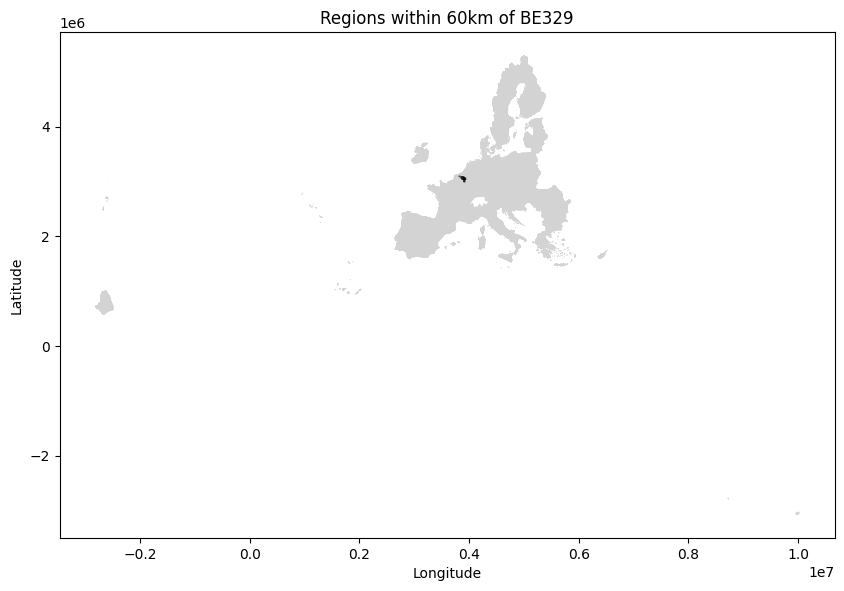

In [27]:
map_neighbours(gdf, 'BE329', 60)

In [28]:
csv_file_path = 'regional_boundaries_neighbours.csv'
gdf_with_neighbours.to_csv(csv_file_path, index=False)

In [29]:
# transform neighbouring columns to str because geopandas can't deal wiht them
gdf_with_neighbours['dist_150'] = gdf_with_neighbours['dist_150'].astype(str)
gdf_with_neighbours['dist_60'] = gdf_with_neighbours['dist_60'].astype(str)

# saving the data
shapefile_path = 'regional_boundaries/regional_boundaries.shp'
gdf_with_neighbours.to_file(shapefile_path, driver='ESRI Shapefile')